# PyTorch and ONNX Prediction

### common functions

In [19]:
import os
from PIL import Image
import torch
from torchvision import transforms
import numpy as np
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

from libs.common import load_dict, img_to_tensor, ensure_tuple, get_random_image, imshow


settings_path = 'settings_torchvision.yaml'
settings = load_dict(settings_path)

input_size = ensure_tuple(settings['input_size'], length=2, dtype=int)
output_dir = settings['output_dir']
model_type = settings['model_type']
model_name = model_type
output_path = os.path.join(output_dir, model_name + ".pth")
json_path = os.path.join(output_dir, model_name + "_metadata.json")
split_data_dir = settings.get('split_data_dir', None)
mean = np.array(settings['mean'])
std = np.array(settings['std'])

# create data loader for test-data
test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

# get a random image from the validation set
image_path = get_random_image('dataset/test/ants', seed=13)
img = Image.open(image_path)

# load class labels from metadata.json
class_labels = load_dict(json_path)["class_labels"]


# Pytorch prediction

Predicted: ants (0.79)


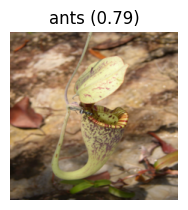

In [ ]:
device = torch.device("cpu")  # ("cuda:0" if torch.cuda.is_available() else "cpu")

def torch_predict(model, image, class_labels):
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(image)
        
        # Get the predicted class and probability
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        top_prob, top_class = probabilities.topk(1, dim=1)
        
        # Get the predicted class name and probability
        class_label = class_labels[top_class[0][0]]
        probability = top_prob[0][0].item()
    return class_label, probability


image_tensor = img_to_tensor(img, transform=test_transform, device=device)

model = torch.load(output_path, weights_only=False)
model = model.to(device)
model.eval()

predicted_label, probability = torch_predict(model, image_tensor, class_labels)

print(f'Predicted: {predicted_label} ({probability:.2f})')
imshow(f'{predicted_label} ({probability:.2f})', image_tensor)

# ONNX prediction

Predicted: ants (0.79)


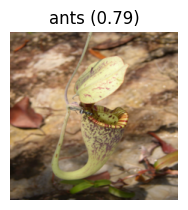

In [ ]:
import onnxruntime as ort
import torch.nn.functional as F


# Load the ONNX model
onnx_path = os.path.join(output_dir, model_name + ".onnx")
ort_session = ort.InferenceSession(onnx_path)


# Preprocess the input image
def load_onnx_tensor(image_path):
    image = Image.open(image_path)
    image_tensor = test_transform(image)
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor


# Run inference
def onnx_predict(input_batch):
    ort_inputs = {ort_session.get_inputs()[0].name: input_batch}
    ort_outs = ort_session.run(None, ort_inputs)

    # Convert logits to probabilities
    logits = ort_outs[0]
    probabilities = F.softmax(torch.tensor(logits), dim=1).numpy()
    
    # Get the top predicted class
    top_class_idx = np.argmax(probabilities, axis=1)[0]
    top_class_label = class_labels[top_class_idx]
    top_class_prob = probabilities[0][top_class_idx]
    
    return top_class_label, top_class_prob


image_tensor = load_onnx_tensor(image_path)
predicted_label, probability = onnx_predict(image_tensor.numpy())

print(f"Predicted: {predicted_label} ({probability:.2f})")
imshow(f'{predicted_label} ({probability:.2f})', image_tensor)